# Import libraries

In [76]:
import os
import re
import psycopg2
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import sklearn.metrics as metrics

# Postgres conection

In [2]:
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'mimiciv'

In [3]:
# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

In [4]:
# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

# Get numeric vitals with > 80% coverage

In [5]:
top_vitals = ["heart_rate", "respiratory_rate", "o_saturation_pulseoxymetry", "heart_rhythm", "gcs_eye_opening", "gcs_verbal_response", "gcs_motor_response", "alarms_on", "head_of_bed", "rul_lung_sounds", "lul_lung_sounds", "temperature_site", "heart_rate_alarm_low", "heart_rate_alarm_high", "rll_lung_sounds", "turn", "lll_lung_sounds", "parameters_checked", "o_saturation_pulseoxymetry_alarm_low", "o_saturation_pulseoxymetry_alarm_high", "resp_alarm_high", "resp_alarm_low", "abdominal_assessment", "skin_integrity", "skin_temperature", "oral_cavity", "skin_condition", "bowel_sounds", "activity_tolerance", "skin_color", "pain_present", "braden_sensory_perception", "braden_mobility", "braden_moisture", "braden_activity", "braden_nutrition", "braden_friction_shear", "non_invasive_blood_pressure_mean", "non_invasive_blood_pressure_systolic", "non_invasive_blood_pressure_diastolic", "spo_desat_limit", "o_delivery_device_s_", "temperature_fahrenheit", "diet_type", "urine_source", "edema_location", "position", "dorsal_pedpulse_r", "dorsal_pedpulse_l", "iv_saline_lock", "gait_transferring", "ambulatory_aid", "mental_status", "secondary_diagnosis", "history_of_falling_within_mnths_", "ectopy_type__x", "sodium_serum_", "potassium_serum_", "chloride_serum_", "creatinine_serum_", "bun", "hco_serum_", "anion_gap", "hematocrit_serum_", "glucose_serum_", "hemoglobin", "platelet_count", "wbc", "pain_location", "cough_effort", "non_invasive_blood_pressure_alarm_low", "non_invasive_blood_pressure_alarm_high", "magnesium", "nbp_alarm_source", "urine_color", "education_learner", "education_topic", "education_barrier", "education_method", "education_response", "urine_appearance", "side_rails_x", "safety_measures", "admission_weight_kg_", "phosphorous", "calcium_non_ionized", "posttib_pulses_r", "posttib_pulses_l", "pain_level_acceptable", "pain_level", "support_systems", "pupil_size_right", "pupil_size_left", "pain_management", "pupil_response_right", "pupil_response_left", "pain_type", "rle_temp", "lle_temp", "rle_color", "anti_embolic_device", "lle_color", "rue_temp", "lue_temp", "rue_color", "lue_color", "richmond_ras_scale", "nares_r", "nares_l", "pain_assessment_method_x", "cough_type", "prothrombin_time", "inr", "ptt", "capillary_refill_r", "oral_care", "capillary_refill_l", "admission_weight_lbs_", "all_medications_tolerated_without_adverse_side_effects", "family_communication", "pain_cause", "anti_embolic_device_status"]

In [9]:
itemidQuery = query_schema + \
"""
SELECT
itm.itemid,
itm.label, 
itm.abbreviation, 
itm.param_type 
FROM mimiciv.chartevents cev
INNER JOIN mimiciv.d_items itm
ON itm.itemid = cev.itemid
GROUP BY itm.itemid
"""

itemidsDf = pd.read_sql_query(itemidQuery, con)

In [30]:
labels = []
rows = []

for index, row in itemidsDf.iterrows():
    lbl = re.sub("[^a-zA-Z]+", "_", str(row['label'])).lower()
    if lbl in top_vitals:
        labels.append(lbl)
        rows.append(row)

# print(type(rows[0]))
topItemidsDf = pd.DataFrame(rows)
# topItemidsDf
topItemidsDf['lbl'] = labels
topItemidsDf

,itemid,label,abbreviation,param_type,lbl
0,220045,Heart Rate,HR,Numeric,heart_rate
1,220046,Heart rate Alarm - High,HR Alarm - High,Numeric,heart_rate_alarm_high
2,220047,Heart Rate Alarm - Low,HR Alarm - Low,Numeric,heart_rate_alarm_low
3,220048,Heart Rhythm,Heart Rhythm,Text,heart_rhythm
21,220179,Non Invasive Blood Pressure systolic,NBPs,Numeric,non_invasive_blood_pressure_systolic
...,...,...,...,...,...
1217,227684,Safety Measures,Safety Measures,Text,safety_measures
1220,227700,Safety Measures,Safety Measures,Text,safety_measures
1339,227968,All Medications Tolerated without Adverse Side...,All Medications Tolerated,Text,all_medications_tolerated_without_adverse_side...
1340,227969,Safety Measures,Safety Measures,Text,safety_measures


In [48]:
numericItems = topItemidsDf[topItemidsDf['param_type'] == 'Numeric'][['itemid', 'lbl']]
numericItems

,itemid,lbl
0,220045,heart_rate
1,220046,heart_rate_alarm_high
2,220047,heart_rate_alarm_low
21,220179,non_invasive_blood_pressure_systolic
22,220180,non_invasive_blood_pressure_diastolic
23,220181,non_invasive_blood_pressure_mean
25,220210,respiratory_rate
28,220228,hemoglobin
32,220277,o_saturation_pulseoxymetry
38,220545,hematocrit_serum_


# Get data

In [62]:
itemidQuery = query_schema + \
"""
    WITH vitals_stg_1 AS
    (
        SELECT icu.stay_id, cev.charttime, cev.valuenum
        , CASE
                WHEN itemid = 220045 THEN 'heart_rate'
                WHEN itemid = 220046 THEN 'heart_rate_alarm_high'
                WHEN itemid = 220047 THEN 'heart_rate_alarm_low'
                WHEN itemid = 220179 THEN 'non_invasive_blood_pressure_systolic'
                WHEN itemid = 220180 THEN 'non_invasive_blood_pressure_diastolic'
                WHEN itemid = 220181 THEN 'non_invasive_blood_pressure_mean'
                WHEN itemid = 220210 THEN 'respiratory_rate'
                WHEN itemid = 220228 THEN 'hemoglobin'
                WHEN itemid = 220277 THEN 'o_saturation_pulseoxymetry'
                WHEN itemid = 220545 THEN 'hematocrit_serum_'
                WHEN itemid = 220546 THEN 'wbc'
                WHEN itemid = 220602 THEN 'chloride_serum_'
                WHEN itemid = 220615 THEN 'creatinine_serum_'
                WHEN itemid = 220621 THEN 'glucose_serum_'
                WHEN itemid = 220635 THEN 'magnesium'
                WHEN itemid = 220645 THEN 'sodium_serum_'
                WHEN itemid = 223751 THEN 'non_invasive_blood_pressure_alarm_high'
                WHEN itemid = 223752 THEN 'non_invasive_blood_pressure_alarm_low'
                WHEN itemid = 223761 THEN 'temperature_fahrenheit'
                WHEN itemid = 223769 THEN 'o_saturation_pulseoxymetry_alarm_high'
                WHEN itemid = 223770 THEN 'o_saturation_pulseoxymetry_alarm_low'
                WHEN itemid = 224161 THEN 'resp_alarm_high'
                WHEN itemid = 224162 THEN 'resp_alarm_low'
                WHEN itemid = 225624 THEN 'bun'
                WHEN itemid = 225625 THEN 'calcium_non_ionized'
                WHEN itemid = 225677 THEN 'phosphorous'
                WHEN itemid = 226253 THEN 'spo_desat_limit'
                WHEN itemid = 226512 THEN 'admission_weight_kg_'
                WHEN itemid = 226531 THEN 'admission_weight_lbs_'
                WHEN itemid = 227073 THEN 'anion_gap'
            ELSE null
            END AS label
        FROM mimiciv.icustays icu
        INNER JOIN mimiciv.chartevents cev
        ON cev.stay_id = icu.stay_id
        AND cev.charttime >= icu.intime
        AND cev.charttime <= icu.intime + interval '24 hour'
        WHERE cev.itemid IN
        (
            220045,
            220046,
            220047,
            220179,
            220180,
            220181,
            220210,
            220228,
            220277,
            220545,
            220546,
            220602,
            220615,
            220621,
            220635,
            220645,
            223751,
            223752,
            223761,
            223769,
            223770,
            224161,
            224162,
            225624,
            225625,
            225677,
            226253,
            226512,
            226531,
            227073
        )
        AND valuenum IS NOT null
    )
    , vitals_stg_2 AS
    (
    SELECT
        stay_id, valuenum, label
        , ROW_NUMBER() OVER (PARTITION BY stay_id, label ORDER BY charttime) AS rn
    FROM vitals_stg_1
    )
    , vitals_stg_3 AS
    (
    SELECT
        stay_id
        , rn
        , COALESCE(MAX(CASE WHEN label = 'heart_rate' THEN valuenum ELSE null END)) AS heart_rate
        , COALESCE(MAX(CASE WHEN label = 'heart_rate_alarm_high' THEN valuenum ELSE null END)) AS heart_rate_alarm_high
        , COALESCE(MAX(CASE WHEN label = 'heart_rate_alarm_low' THEN valuenum ELSE null END)) AS heart_rate_alarm_low
        , COALESCE(MAX(CASE WHEN label = 'non_invasive_blood_pressure_systolic' THEN valuenum ELSE null END)) AS non_invasive_blood_pressure_systolic
        , COALESCE(MAX(CASE WHEN label = 'non_invasive_blood_pressure_diastolic' THEN valuenum ELSE null END)) AS non_invasive_blood_pressure_diastolic
        , COALESCE(MAX(CASE WHEN label = 'non_invasive_blood_pressure_mean' THEN valuenum ELSE null END)) AS non_invasive_blood_pressure_mean
        , COALESCE(MAX(CASE WHEN label = 'respiratory_rate' THEN valuenum ELSE null END)) AS respiratory_rate
        , COALESCE(MAX(CASE WHEN label = 'hemoglobin' THEN valuenum ELSE null END)) AS hemoglobin
        , COALESCE(MAX(CASE WHEN label = 'o_saturation_pulseoxymetry' THEN valuenum ELSE null END)) AS o_saturation_pulseoxymetry
        , COALESCE(MAX(CASE WHEN label = 'hematocrit_serum_' THEN valuenum ELSE null END)) AS hematocrit_serum_
        , COALESCE(MAX(CASE WHEN label = 'wbc' THEN valuenum ELSE null END)) AS wbc
        , COALESCE(MAX(CASE WHEN label = 'chloride_serum_' THEN valuenum ELSE null END)) AS chloride_serum_
        , COALESCE(MAX(CASE WHEN label = 'creatinine_serum_' THEN valuenum ELSE null END)) AS creatinine_serum_
        , COALESCE(MAX(CASE WHEN label = 'glucose_serum_' THEN valuenum ELSE null END)) AS glucose_serum_
        , COALESCE(MAX(CASE WHEN label = 'magnesium' THEN valuenum ELSE null END)) AS magnesium
        , COALESCE(MAX(CASE WHEN label = 'sodium_serum_' THEN valuenum ELSE null END)) AS sodium_serum_
        , COALESCE(MAX(CASE WHEN label = 'non_invasive_blood_pressure_alarm_high' THEN valuenum ELSE null END)) AS non_invasive_blood_pressure_alarm_high
        , COALESCE(MAX(CASE WHEN label = 'non_invasive_blood_pressure_alarm_low' THEN valuenum ELSE null END)) AS non_invasive_blood_pressure_alarm_low
        , COALESCE(MAX(CASE WHEN label = 'temperature_fahrenheit' THEN valuenum ELSE null END)) AS temperature_fahrenheit
        , COALESCE(MAX(CASE WHEN label = 'o_saturation_pulseoxymetry_alarm_high' THEN valuenum ELSE null END)) AS o_saturation_pulseoxymetry_alarm_high
        , COALESCE(MAX(CASE WHEN label = 'o_saturation_pulseoxymetry_alarm_low' THEN valuenum ELSE null END)) AS o_saturation_pulseoxymetry_alarm_low
        , COALESCE(MAX(CASE WHEN label = 'resp_alarm_high' THEN valuenum ELSE null END)) AS resp_alarm_high
        , COALESCE(MAX(CASE WHEN label = 'resp_alarm_low' THEN valuenum ELSE null END)) AS resp_alarm_low
        , COALESCE(MAX(CASE WHEN label = 'bun' THEN valuenum ELSE null END)) AS bun
        , COALESCE(MAX(CASE WHEN label = 'calcium_non_ionized' THEN valuenum ELSE null END)) AS calcium_non_ionized
        , COALESCE(MAX(CASE WHEN label = 'phosphorous' THEN valuenum ELSE null END)) AS phosphorous
        , COALESCE(MAX(CASE WHEN label = 'spo_desat_limit' THEN valuenum ELSE null END)) AS spo_desat_limit
        , COALESCE(MAX(CASE WHEN label = 'admission_weight_kg_' THEN valuenum ELSE null END)) AS admission_weight_kg_
        , COALESCE(MAX(CASE WHEN label = 'admission_weight_lbs_' THEN valuenum ELSE null END)) AS admission_weight_lbs_
        , COALESCE(MAX(CASE WHEN label = 'anion_gap' THEN valuenum ELSE null END)) AS anion_gap
    FROM vitals_stg_2
    GROUP BY stay_id, rn
    )
    , vitals_stg_4 AS
    (
        SELECT
        stay_id,
        AVG(heart_rate) AS heart_rate,
        AVG(heart_rate_alarm_high) AS heart_rate_alarm_high,
        AVG(heart_rate_alarm_low) AS heart_rate_alarm_low,
        AVG(non_invasive_blood_pressure_systolic) AS non_invasive_blood_pressure_systolic,
        AVG(non_invasive_blood_pressure_diastolic) AS non_invasive_blood_pressure_diastolic,
        AVG(non_invasive_blood_pressure_mean) AS non_invasive_blood_pressure_mean,
        AVG(respiratory_rate) AS respiratory_rate,
        AVG(hemoglobin) AS hemoglobin,
        AVG(o_saturation_pulseoxymetry) AS o_saturation_pulseoxymetry,
        AVG(hematocrit_serum_) AS hematocrit_serum_,
        AVG(wbc) AS wbc,
        AVG(chloride_serum_) AS chloride_serum_,
        AVG(creatinine_serum_) AS creatinine_serum_,
        AVG(glucose_serum_) AS glucose_serum_,
        AVG(magnesium) AS magnesium,
        AVG(sodium_serum_) AS sodium_serum_,
        AVG(non_invasive_blood_pressure_alarm_high) AS non_invasive_blood_pressure_alarm_high,
        AVG(non_invasive_blood_pressure_alarm_low) AS non_invasive_blood_pressure_alarm_low,
        AVG(temperature_fahrenheit) AS temperature_fahrenheit,
        AVG(o_saturation_pulseoxymetry_alarm_high) AS o_saturation_pulseoxymetry_alarm_high,
        AVG(o_saturation_pulseoxymetry_alarm_low) AS o_saturation_pulseoxymetry_alarm_low,
        AVG(resp_alarm_high) AS resp_alarm_high,
        AVG(resp_alarm_low) AS resp_alarm_low,
        AVG(bun) AS bun,
        AVG(calcium_non_ionized) AS calcium_non_ionized,
        AVG(phosphorous) AS phosphorous,
        AVG(spo_desat_limit) AS spo_desat_limit,
        AVG(admission_weight_kg_) AS admission_weight_kg_,
        AVG(admission_weight_lbs_) AS admission_weight_lbs_,
        AVG(anion_gap) AS anion_gap
        FROM vitals_stg_3
        GROUP BY stay_id
    )
    SELECT * FROM vitals_stg_4
"""
# """
# SELECT
# *
# FROM mimiciv.chartevents cev
# WHERE cev.itemid IN """ + str(numericItemIds).replace('[', '(').replace(']', ')') + """
# """

itemidsDf = pd.read_sql_query(itemidQuery, con)

In [63]:
itemidsDf

,stay_id,heart_rate,heart_rate_alarm_high,heart_rate_alarm_low,non_invasive_blood_pressure_systolic,non_invasive_blood_pressure_diastolic,non_invasive_blood_pressure_mean,respiratory_rate,hemoglobin,o_saturation_pulseoxymetry,...,o_saturation_pulseoxymetry_alarm_low,resp_alarm_high,resp_alarm_low,bun,calcium_non_ionized,phosphorous,spo_desat_limit,admission_weight_kg_,admission_weight_lbs_,anion_gap
0,30000153,106.840000,127.500000,60.000000,137.111111,72.000000,86.333333,15.076923,10.30,96.640000,...,90.000000,32.500000,10.000000,22.000000,7.700000,3.650000,85.000000,NaN,NaN,12.000000
1,30000213,81.680000,130.000000,45.000000,134.920000,56.160000,79.120000,19.080000,7.40,98.960000,...,92.000000,35.000000,8.000000,60.666667,8.333333,5.733333,86.500000,NaN,NaN,15.666667
2,30000484,89.958333,120.000000,50.000000,105.750000,55.625000,65.083333,14.708333,8.10,99.791667,...,90.000000,30.000000,8.000000,47.000000,7.800000,1.900000,85.000000,NaN,150.7,10.000000
3,30000646,86.423729,120.000000,60.000000,92.703704,56.481481,64.666667,25.627119,13.00,95.610169,...,91.600000,39.000000,8.000000,11.000000,7.400000,3.100000,85.000000,NaN,168.1,12.333333
4,30001148,75.520000,100.000000,60.000000,106.333333,56.666667,68.500000,14.740741,10.10,98.360000,...,92.000000,31.666667,8.000000,10.500000,NaN,NaN,85.000000,65.7,144.5,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76517,39999301,59.884615,120.000000,50.000000,135.571429,87.714286,99.250000,15.807692,11.40,94.200000,...,90.000000,31.666667,8.000000,19.500000,8.800000,3.500000,85.000000,NaN,NaN,13.500000
76518,39999384,70.840000,125.000000,70.000000,137.600000,51.200000,72.700000,18.040000,7.85,98.160000,...,90.000000,35.000000,8.000000,91.000000,8.600000,5.400000,88.000000,NaN,147.4,16.000000
76519,39999552,85.125000,116.666667,60.000000,128.000000,66.000000,81.800000,16.571429,9.78,98.142857,...,92.000000,35.000000,8.000000,10.000000,8.800000,4.100000,85.000000,NaN,NaN,11.500000
76520,39999562,101.440000,100.000000,51.428571,136.384615,79.461538,95.615385,NaN,NaN,93.800000,...,92.000000,29.285714,8.285714,NaN,NaN,NaN,88.000000,NaN,NaN,NaN


# Save data

In [70]:
outpath = os.getcwd() + '/../../data/mimic_top_numeric_vitals.csv'
itemidsDf.to_csv(outpath)

# Read anomaly file

In [71]:
anomalypath = os.getcwd() + '/../../data/mimic_top_numeric_vitals_anomalies.csv'
anomalies_df = pd.read_csv(anomalypath)

In [72]:
anomalies_df

,stay_id,heart_rate,heart_rate_alarm_high,heart_rate_alarm_low,non_invasive_blood_pressure_systolic,non_invasive_blood_pressure_diastolic,non_invasive_blood_pressure_mean,respiratory_rate,hemoglobin,o_saturation_pulseoxymetry,...,spo_desat_limit,admission_weight_kg_,admission_weight_lbs_,anion_gap,y_knn_agg,y_lof,y_inflo,y_kdeos,y_ldf,ensemble_scores
0,30000153,106.840000,127.500000,60.000000,137.111111,72.000000,86.333333,15.076923,10.30,96.640000,...,85.000000,0.0,0.0,12.000000,3634.987255,1.093453,0.890150,0.279920,0.935516,4.311311
1,30000213,81.680000,130.000000,45.000000,134.920000,56.160000,79.120000,19.080000,7.40,98.960000,...,86.500000,0.0,0.0,15.666667,4528.195886,1.083567,0.860502,0.821136,0.935722,4.526844
2,30000484,89.958333,120.000000,50.000000,105.750000,55.625000,65.083333,14.708333,8.10,99.791667,...,85.000000,0.0,150.7,10.000000,3890.845865,1.035211,0.972753,0.626656,0.820872,4.061090
3,30000646,86.423729,120.000000,60.000000,92.703704,56.481481,64.666667,25.627119,13.00,95.610169,...,85.000000,0.0,168.1,12.333333,4162.207521,0.979509,0.963948,0.433535,0.461619,3.552068
4,30001148,75.520000,100.000000,60.000000,106.333333,56.666667,68.500000,14.740741,10.10,98.360000,...,85.000000,65.7,144.5,10.000000,5790.990963,1.006250,0.882803,0.580526,0.673494,4.203557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76517,39999301,59.884615,120.000000,50.000000,135.571429,87.714286,99.250000,15.807692,11.40,94.200000,...,85.000000,0.0,0.0,13.500000,7262.859234,1.471319,0.809738,0.083336,0.998970,6.020910
76518,39999384,70.840000,125.000000,70.000000,137.600000,51.200000,72.700000,18.040000,7.85,98.160000,...,88.000000,0.0,147.4,16.000000,7977.073769,1.164077,1.108124,0.439481,0.998985,5.683207
76519,39999552,85.125000,116.666667,60.000000,128.000000,66.000000,81.800000,16.571429,9.78,98.142857,...,85.000000,0.0,0.0,11.500000,2707.986901,1.012405,0.955783,0.131583,0.703469,3.365533
76520,39999562,101.440000,100.000000,51.428571,136.384615,79.461538,95.615385,0.000000,0.00,93.800000,...,88.000000,0.0,0.0,0.000000,5045.561537,1.762048,0.403767,0.616934,0.993433,5.675654


In [73]:
attributes = ['heart_rate', 'heart_rate_alarm_high', 'heart_rate_alarm_low', 'non_invasive_blood_pressure_systolic', 'non_invasive_blood_pressure_diastolic', 'non_invasive_blood_pressure_mean', 'respiratory_rate', 'hemoglobin', 'o_saturation_pulseoxymetry', 'hematocrit_serum_', 'wbc', 'chloride_serum_', 'creatinine_serum_', 'glucose_serum_', 'magnesium', 'sodium_serum_', 'non_invasive_blood_pressure_alarm_high', 'non_invasive_blood_pressure_alarm_low', 'temperature_fahrenheit', 'o_saturation_pulseoxymetry_alarm_high', 'o_saturation_pulseoxymetry_alarm_low', 'resp_alarm_high', 'resp_alarm_low', 'bun', 'calcium_non_ionized', 'phosphorous', 'spo_desat_limit', 'admission_weight_kg_', 'admission_weight_lbs_', 'anion_gap']

# PCA without scaling

In [77]:
pca = PCA(n_components=2)
pca.fit(anomalies_df[attributes])

PCA(n_components=2)

In [79]:
pca.explained_variance_ratio_

array([0.58144629, 0.18194877])

In [80]:
pca.singular_values_

array([5431972.24892773, 3038626.41869387])

In [81]:
pca.n_features_in_

30

In [82]:
pca.feature_names_in_

array(['heart_rate', 'heart_rate_alarm_high', 'heart_rate_alarm_low',
       'non_invasive_blood_pressure_systolic',
       'non_invasive_blood_pressure_diastolic',
       'non_invasive_blood_pressure_mean', 'respiratory_rate',
       'hemoglobin', 'o_saturation_pulseoxymetry', 'hematocrit_serum_',
       'wbc', 'chloride_serum_', 'creatinine_serum_', 'glucose_serum_',
       'magnesium', 'sodium_serum_',
       'non_invasive_blood_pressure_alarm_high',
       'non_invasive_blood_pressure_alarm_low', 'temperature_fahrenheit',
       'o_saturation_pulseoxymetry_alarm_high',
       'o_saturation_pulseoxymetry_alarm_low', 'resp_alarm_high',
       'resp_alarm_low', 'bun', 'calcium_non_ionized', 'phosphorous',
       'spo_desat_limit', 'admission_weight_kg_', 'admission_weight_lbs_',
       'anion_gap'], dtype=object)

In [83]:
anomalies_pca = pca.transform(anomalies_df[attributes])

In [85]:
anomalies_pca1 = [row[0] for row in anomalies_pca]

In [86]:
anomalies_pca2 = [row[1] for row in anomalies_pca]

In [87]:
anomalies_df['pca1'] = anomalies_pca1

In [88]:
anomalies_df['pca2'] = anomalies_pca2

In [89]:
anomalies_df.head()

,stay_id,heart_rate,heart_rate_alarm_high,heart_rate_alarm_low,non_invasive_blood_pressure_systolic,non_invasive_blood_pressure_diastolic,non_invasive_blood_pressure_mean,respiratory_rate,hemoglobin,o_saturation_pulseoxymetry,...,admission_weight_lbs_,anion_gap,y_knn_agg,y_lof,y_inflo,y_kdeos,y_ldf,ensemble_scores,pca1,pca2
0,30000153,106.840000,127.5,60.0,137.111111,72.000000,86.333333,15.076923,10.3,96.640000,...,0.0,12.000000,3634.987255,1.093453,0.890150,0.279920,0.935516,4.311311,-116.110875,-194.933993
1,30000213,81.680000,130.0,45.0,134.920000,56.160000,79.120000,19.080000,7.4,98.960000,...,0.0,15.666667,4528.195886,1.083567,0.860502,0.821136,0.935722,4.526844,-118.113504,-174.531413
2,30000484,89.958333,120.0,50.0,105.750000,55.625000,65.083333,14.708333,8.1,99.791667,...,150.7,10.000000,3890.845865,1.035211,0.972753,0.626656,0.820872,4.061090,-118.103387,-221.631842
3,30000646,86.423729,120.0,60.0,92.703704,56.481481,64.666667,25.627119,13.0,95.610169,...,168.1,12.333333,4162.207521,0.979509,0.963948,0.433535,0.461619,3.552068,-118.103352,-220.301322
4,30001148,75.520000,100.0,60.0,106.333333,56.666667,68.500000,14.740741,10.1,98.360000,...,144.5,10.000000,5790.990963,1.006250,0.882803,0.580526,0.673494,4.203557,-118.104270,-227.202850


<AxesSubplot:xlabel='pca1', ylabel='pca2'>

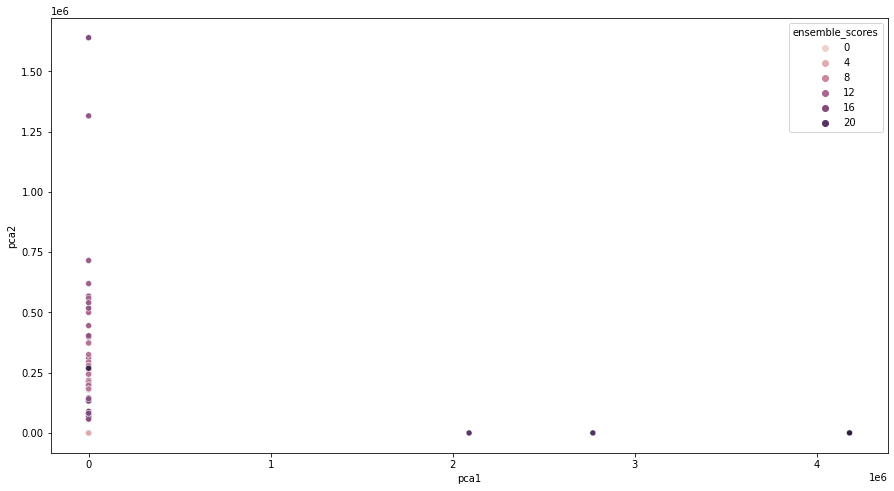

In [90]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data = anomalies_df,
    x = 'pca1', 
    y = 'pca2', 
    hue = "ensemble_scores",
)

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

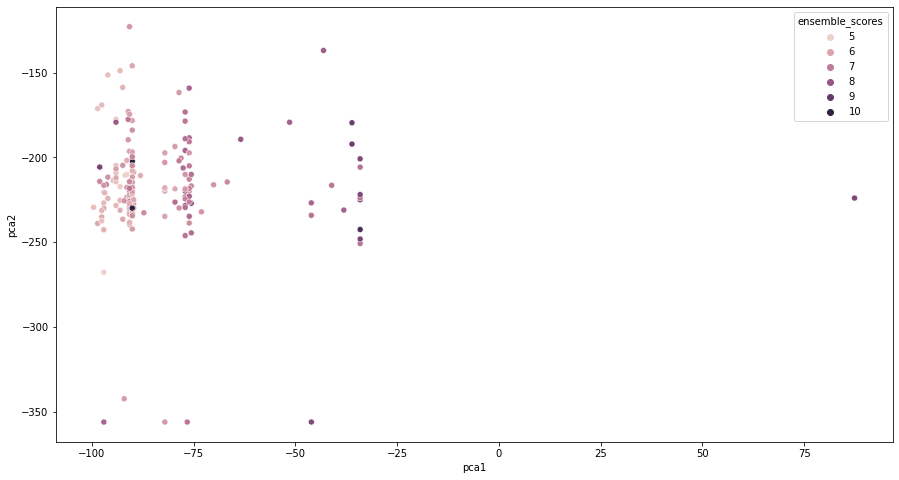

In [94]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data = anomalies_df[
        (anomalies_df.pca2 < 100) & 
        (anomalies_df.pca1 < 100) &
        (anomalies_df.pca1 > -100)
    ],
    x = 'pca1', 
    y = 'pca2', 
    hue = "ensemble_scores",
)

# PCA - with scaling

In [95]:
for attribute in attributes:
    anomalies_df[attribute + '_norm'] = (anomalies_df[attribute] - anomalies_df[attribute].mean())/anomalies_df[attribute].std()

In [96]:
n_pca = PCA(n_components=2)
n_pca.fit(anomalies_df[[attribute + '_norm' for attribute in attributes]])

PCA(n_components=2)

In [97]:
n_pca.explained_variance_ratio_

array([0.21684787, 0.06842761])

In [98]:
n_pca.singular_values_

array([705.5511871 , 396.33884234])

In [99]:
n_pca.n_features_in_

30

In [100]:
n_pca.feature_names_in_

array(['heart_rate_norm', 'heart_rate_alarm_high_norm',
       'heart_rate_alarm_low_norm',
       'non_invasive_blood_pressure_systolic_norm',
       'non_invasive_blood_pressure_diastolic_norm',
       'non_invasive_blood_pressure_mean_norm', 'respiratory_rate_norm',
       'hemoglobin_norm', 'o_saturation_pulseoxymetry_norm',
       'hematocrit_serum__norm', 'wbc_norm', 'chloride_serum__norm',
       'creatinine_serum__norm', 'glucose_serum__norm', 'magnesium_norm',
       'sodium_serum__norm',
       'non_invasive_blood_pressure_alarm_high_norm',
       'non_invasive_blood_pressure_alarm_low_norm',
       'temperature_fahrenheit_norm',
       'o_saturation_pulseoxymetry_alarm_high_norm',
       'o_saturation_pulseoxymetry_alarm_low_norm',
       'resp_alarm_high_norm', 'resp_alarm_low_norm', 'bun_norm',
       'calcium_non_ionized_norm', 'phosphorous_norm',
       'spo_desat_limit_norm', 'admission_weight_kg__norm',
       'admission_weight_lbs__norm', 'anion_gap_norm'], dtype=obje

In [101]:
anomalies_n_pca = n_pca.transform(anomalies_df[[attribute + '_norm' for attribute in attributes]])

In [102]:
anomalies_n_pca1 = [row[0] for row in anomalies_n_pca]

In [103]:
anomalies_n_pca2 = [row[1] for row in anomalies_n_pca]

In [104]:
anomalies_df['n_pca1'] = anomalies_n_pca1

In [105]:
anomalies_df['n_pca2'] = anomalies_n_pca2

In [106]:
anomalies_df.head()

,stay_id,heart_rate,heart_rate_alarm_high,heart_rate_alarm_low,non_invasive_blood_pressure_systolic,non_invasive_blood_pressure_diastolic,non_invasive_blood_pressure_mean,respiratory_rate,hemoglobin,o_saturation_pulseoxymetry,...,resp_alarm_low_norm,bun_norm,calcium_non_ionized_norm,phosphorous_norm,spo_desat_limit_norm,admission_weight_kg__norm,admission_weight_lbs__norm,anion_gap_norm,n_pca1,n_pca2
0,30000153,106.840000,127.5,60.0,137.111111,72.000000,86.333333,15.076923,10.3,96.640000,...,-0.005914,-0.016697,-0.007628,-0.007595,0.032054,-0.158572,-0.708905,-0.004526,-0.030348,-0.010134
1,30000213,81.680000,130.0,45.0,134.920000,56.160000,79.120000,19.080000,7.4,98.960000,...,-0.006016,-0.009383,-0.007424,-0.006923,0.108665,-0.158572,-0.708905,-0.002498,-0.029643,-0.014774
2,30000484,89.958333,120.0,50.0,105.750000,55.625000,65.083333,14.708333,8.1,99.791667,...,-0.006016,-0.011968,-0.007596,-0.008159,0.032054,-0.158572,0.151075,-0.005633,-0.034811,-0.015271
3,30000646,86.423729,120.0,60.0,92.703704,56.481481,64.666667,25.627119,13.0,95.610169,...,-0.006016,-0.018777,-0.007725,-0.007772,0.032054,-0.158572,0.250370,-0.004342,-0.034818,-0.015066
4,30001148,75.520000,100.0,60.0,106.333333,56.666667,68.500000,14.740741,10.1,98.360000,...,-0.006016,-0.018872,-0.010111,-0.008771,0.032054,4.607967,0.115695,-0.005633,-0.025606,-0.005334


<AxesSubplot:xlabel='n_pca1', ylabel='n_pca2'>

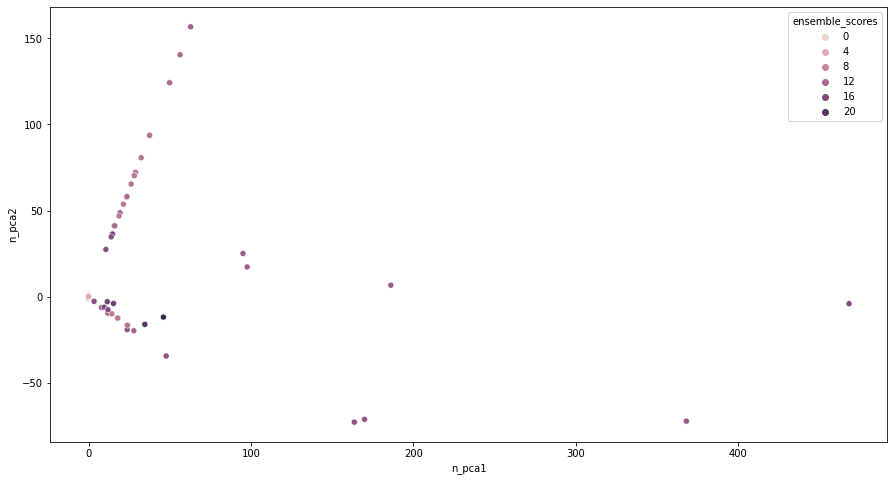

In [107]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data = anomalies_df,
    x = 'n_pca1', 
    y = 'n_pca2', 
    hue = "ensemble_scores",
)

<AxesSubplot:xlabel='n_pca1', ylabel='n_pca2'>

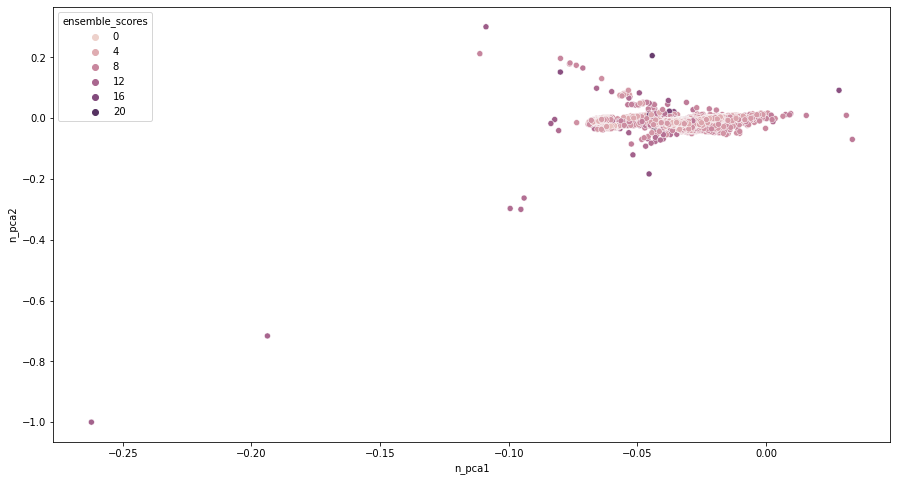

In [109]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data = anomalies_df[
        (anomalies_df.n_pca2 < 0.5) & 
        (anomalies_df.n_pca1 < 0.5) &
        (anomalies_df.n_pca1 > -0.5)
    ],
    x = 'n_pca1', 
    y = 'n_pca2', 
    hue = 'ensemble_scores',
)

# Missing values

In [110]:
anomalies_df['is_missing'] = [False] * anomalies_df.shape[0]

In [111]:
for attribute in attributes:
    anomalies_df['is_missing'] = (anomalies_df['is_missing']) | (anomalies_df[attribute] == 0)

In [112]:
anomalies_df.groupby('is_missing')['ensemble_scores'].mean()

is_missing
False    4.906542
True     4.418146
Name: ensemble_scores, dtype: float64

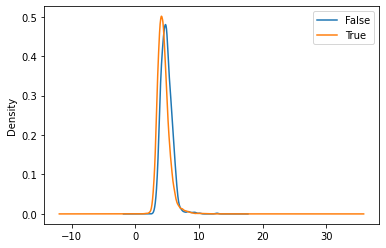

In [114]:
fig, ax = plt.subplots()

for key, grp in anomalies_df.groupby('is_missing')['ensemble_scores']:
    ax = grp.plot(ax=ax, kind='density', x='ensemble_scores', label=key)

plt.legend(loc='best')
plt.show()

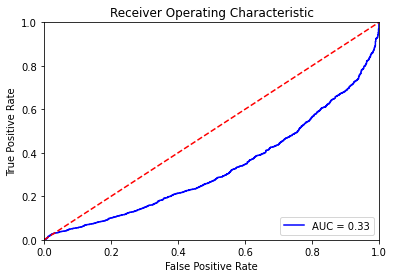

In [115]:
fpr, tpr, threshold = metrics.roc_curve(
    anomalies_df['is_missing'],
    anomalies_df['ensemble_scores'], 
)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

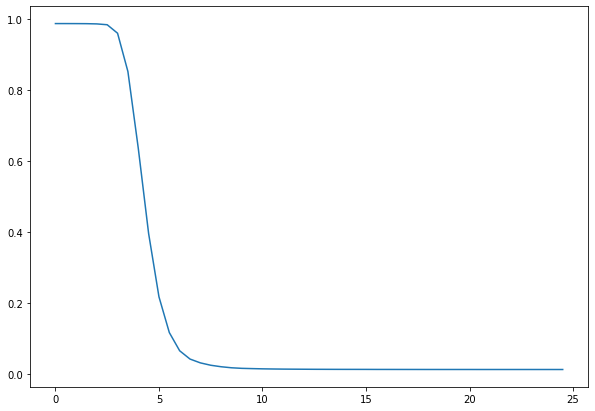

In [116]:
x = []
y = []
for i in np.arange(0, 25, 0.5):
    x.append(i)
    y.append(metrics.accuracy_score(
        anomalies_df['is_missing'], 
        (anomalies_df['ensemble_scores'] > i)
    ))

plt.figure(figsize=(10,7))
plt.plot(x, y)

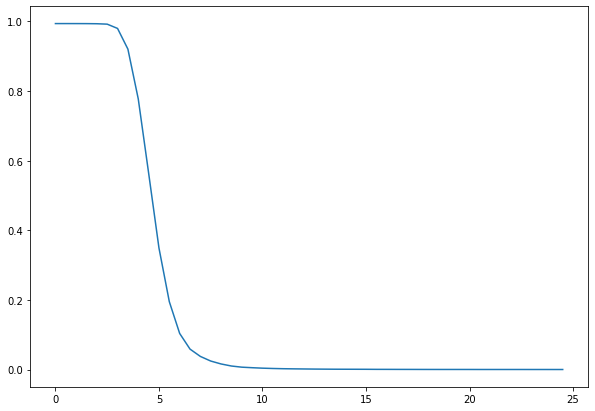

In [117]:
x = []
y = []
for i in np.arange(0, 25, 0.5):
    x.append(i)
    y.append(metrics.f1_score(
        anomalies_df['is_missing'], 
        (anomalies_df['ensemble_scores'] > i)
    ))

plt.figure(figsize=(10,7))
plt.plot(x, y)

In [119]:
sum(anomalies_df[anomalies_df['ensemble_scores'] > 5.5]['is_missing'])/sum(anomalies_df['is_missing'])

0.1082275716951418

# Outliers

In [120]:
anomalies_df['is_outlier'] = [False] * anomalies_df.shape[0]

In [121]:
for attribute in attributes:
    q1 = anomalies_df[attribute].quantile(0.25)
    q3 = anomalies_df[attribute].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    anomalies_df['is_outlier'] = (anomalies_df['is_outlier']) | (anomalies_df[attribute] < fence_low) | (anomalies_df[attribute] > fence_high)

In [122]:
anomalies_df.groupby('is_outlier')['ensemble_scores'].mean()

is_outlier
False    3.880059
True     4.716013
Name: ensemble_scores, dtype: float64

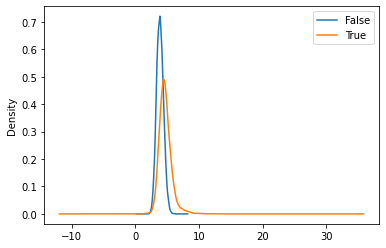

In [126]:
fig, ax = plt.subplots()

for key, grp in anomalies_df.groupby('is_outlier')['ensemble_scores']:
    ax = grp.plot(ax=ax, kind='density', x='ensemble_scores', label=key)

plt.legend(loc='best')
plt.show()

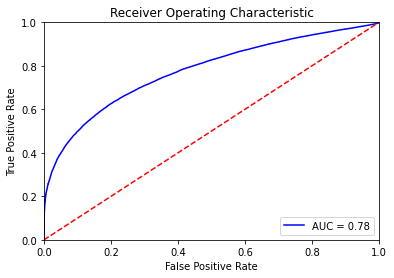

In [127]:
fpr, tpr, threshold = metrics.roc_curve(
    anomalies_df['is_outlier'],
    anomalies_df['ensemble_scores'], 
)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

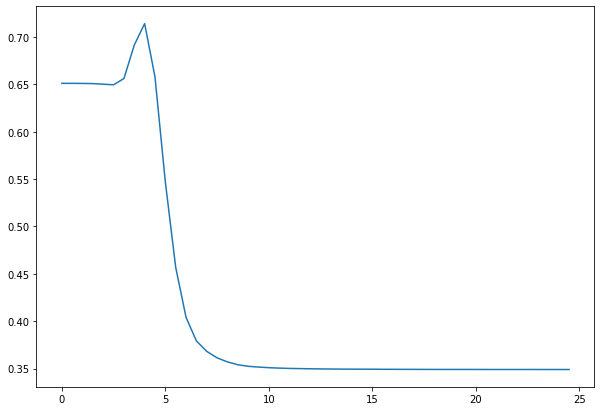

In [128]:
x = []
y = []
for i in np.arange(0, 25, 0.5):
    x.append(i)
    y.append(metrics.accuracy_score(
        anomalies_df['is_outlier'], 
        (anomalies_df['ensemble_scores'] > i)
    ))

plt.figure(figsize=(10,7))
plt.plot(x, y)

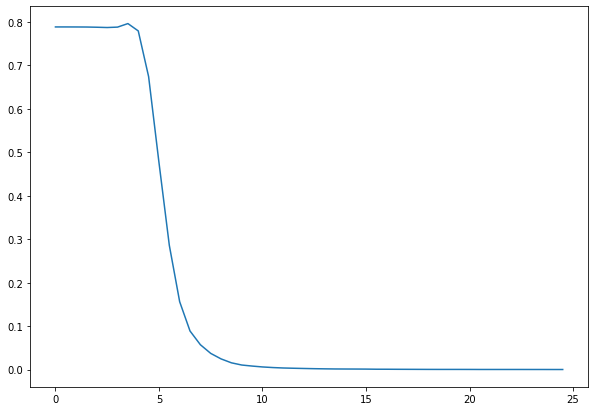

In [130]:
x = []
y = []
for i in np.arange(0, 25, 0.5):
    x.append(i)
    y.append(metrics.f1_score(
        anomalies_df['is_outlier'], 
        (anomalies_df['ensemble_scores'] > i)
    ))

plt.figure(figsize=(10,7))
plt.plot(x, y)

In [132]:
sum(anomalies_df[anomalies_df['ensemble_scores'] > 4.5]['is_outlier'])/sum(anomalies_df['is_outlier'])

0.5441625180664846

In [133]:
sum(anomalies_df[anomalies_df['ensemble_scores'] > 4.5]['is_outlier'])

27108

In [134]:
sum(anomalies_df['is_outlier'])

49816

In [136]:
sum(anomalies_df['ensemble_scores'] > 4.5)

30592

<AxesSubplot:>

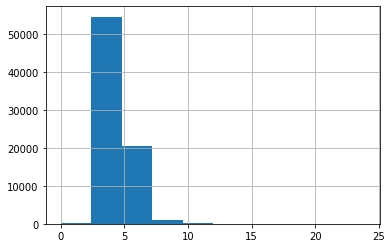

In [137]:
anomalies_df['ensemble_scores'].hist()